Initial weights:
Layer 1: tensor([[-0.1549,  0.1427],
        [-0.3443,  0.4153]])
Layer 2: tensor([[ 0.6233, -0.5188]])

Starting training...
Step 0, Loss: 0.9776, Eigenvalues: ['0.7561', '0.2095']
Step 10, Loss: 0.6061, Eigenvalues: ['0.5125', 'nan']
Step 20, Loss: 0.2061, Eigenvalues: ['0.5033', '-0.0894']
Step 30, Loss: 0.0318, Eigenvalues: ['0.9418', '0.1167']
Step 40, Loss: 0.0031, Eigenvalues: ['1.1336', '0.0259']
Step 50, Loss: 0.0002, Eigenvalues: ['1.1931', '0.0114']
Step 60, Loss: 0.0000, Eigenvalues: ['1.2100', '0.0031']
Step 70, Loss: 0.0000, Eigenvalues: ['1.2146', '0.0009']
Step 80, Loss: 0.0000, Eigenvalues: ['1.2159', '0.0002']
Step 90, Loss: 0.0000, Eigenvalues: ['1.2163', '0.0001']

Final weights:
Layer 1: tensor([[ 0.8401,  0.5233],
        [-1.3825,  0.0181]])
Layer 2: tensor([[ 1.1562, -1.4118]])


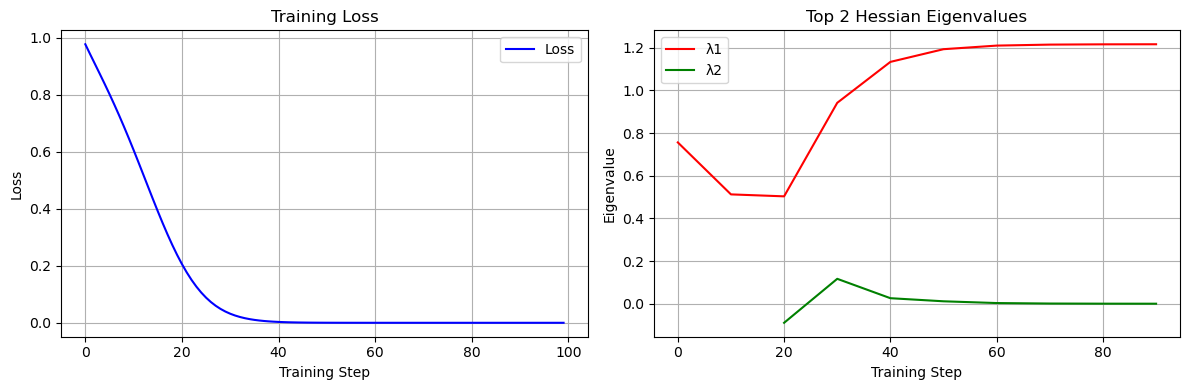

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define simple 2-layer neural network without bias
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Layer 1: 2 inputs -> 2 neurons (no bias)
        self.layer1 = nn.Linear(2, 2, bias=False)
        # Layer 2: 2 neurons -> 1 output (no bias)
        self.layer2 = nn.Linear(2, 1, bias=False)
        
    def forward(self, x):
        x = torch.tanh(self.layer1(x))  # Activation after first layer
        x = self.layer2(x)             # Linear output
        return x

# Function to compute top 2 eigenvalues using power iteration
def compute_top_eigenvalues(model, inputs, target, criterion, num_iterations=10):
    model.eval()
    params = [p for p in model.parameters() if p.requires_grad]
    n_params = sum(p.numel() for p in params)
    
    # Compute loss and gradient
    output = model(inputs)
    loss = criterion(output, target)
    grads = torch.autograd.grad(loss, params, create_graph=True)
    grad_vector = torch.cat([g.flatten() for g in grads])
    
    top_eigenvalues = []
    v = torch.randn(n_params)  # Initial random vector
    
    # Compute top 2 eigenvalues
    for _ in range(2):
        v = v / torch.norm(v)
        
        # Power iteration
        for _ in range(num_iterations):
            Hv = torch.zeros_like(v)
            grad_grads = torch.autograd.grad(grad_vector @ v, params, retain_graph=True)
            Hv = torch.cat([gg.flatten() for gg in grad_grads])
            v_new = Hv / torch.norm(Hv)
            v = v_new
        
        # Rayleigh quotient for eigenvalue
        Hv = torch.zeros_like(v)
        grad_grads = torch.autograd.grad(grad_vector @ v, params, retain_graph=True)
        Hv = torch.cat([gg.flatten() for gg in grad_grads])
        eigenvalue = (v @ Hv) / (v @ v)
        top_eigenvalues.append(eigenvalue.item())
        
        # Deflation
        grad_vector = grad_vector - (grad_vector @ v) * v
    
    return top_eigenvalues

# Training function
def train_model(model, inputs, target, criterion, optimizer, num_steps=100):
    losses = []
    eigenvalue_history = []
    
    for step in range(num_steps):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        output = model(inputs)
        loss = criterion(output, target)
        
        # Compute eigenvalues every 10 steps
        if step % 10 == 0:
            eigenvalues = compute_top_eigenvalues(model, inputs, target, criterion)
            eigenvalue_history.append({
                'step': step,
                'eigenvalues': eigenvalues
            })
            print(f"Step {step}, Loss: {loss.item():.4f}, Eigenvalues: {[f'{e:.4f}' for e in eigenvalues]}")
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return losses, eigenvalue_history

# Generate random input and target
inputs = torch.randn(1, 2)  # Random 2D input
target = torch.tensor([[1.0]])  # Random target

# Initialize model and training components
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Print initial weights
print("Initial weights:")
print("Layer 1:", model.layer1.weight.data)
print("Layer 2:", model.layer2.weight.data)

# Train the model
print("\nStarting training...")
losses, eigenvalue_history = train_model(model, inputs, target, criterion, optimizer)

# Print final weights
print("\nFinal weights:")
print("Layer 1:", model.layer1.weight.data)
print("Layer 2:", model.layer2.weight.data)

# Plotting results
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(losses, 'b-', label='Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Eigenvalue plot
steps = [e['step'] for e in eigenvalue_history]
eig1 = [e['eigenvalues'][0] for e in eigenvalue_history]
eig2 = [e['eigenvalues'][1] for e in eigenvalue_history]
plt.subplot(1, 2, 2)
plt.plot(steps, eig1, 'r-', label='λ1')
plt.plot(steps, eig2, 'g-', label='λ2')
plt.xlabel('Training Step')
plt.ylabel('Eigenvalue')
plt.title('Top 2 Hessian Eigenvalues')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Initial weights:
Layer 1: tensor([[-0.1549,  0.1427],
        [-0.3443,  0.4153]])
Layer 2: tensor([[ 0.6233, -0.5188]])

Starting training...
grad_vector: tensor([-0.4145, -0.1586,  0.3440,  0.1316,  0.0668,  0.1233],
       grad_fn=<CatBackward0>)
Iteration 0:
grad_grads: (tensor([[-0.1863, -0.0713],
        [-0.0309, -0.0118]]), tensor([[ 0.6118, -0.0506]]))
Hv: tensor([-0.1863, -0.0713, -0.0309, -0.0118,  0.6118, -0.0506])

Iteration 1:
grad_grads: (tensor([[-0.6628, -0.2536],
        [ 0.0814,  0.0311]]), tensor([[0.2256, 0.0472]]))
Hv: tensor([-0.6628, -0.2536,  0.0814,  0.0311,  0.2256,  0.0472])

Iteration 2:
grad_grads: (tensor([[-0.2940, -0.1125],
        [ 0.0463,  0.0177]]), tensor([[ 0.6894, -0.0515]]))
Hv: tensor([-0.2940, -0.1125,  0.0463,  0.0177,  0.6894, -0.0515])

Iteration 3:
grad_grads: (tensor([[-0.6531, -0.2499],
        [ 0.0916,  0.0350]]), tensor([[ 0.3034, -0.0299]]))
Hv: tensor([-0.6531, -0.2499,  0.0916,  0.0350,  0.3034, -0.0299])

Iteration 4:
grad_grads:

/var/folders/zy/53q03bqx77bflc8psn3qmjrm0000gn/T/ipykernel_21145/114813512.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(approx_eigvecs[i])


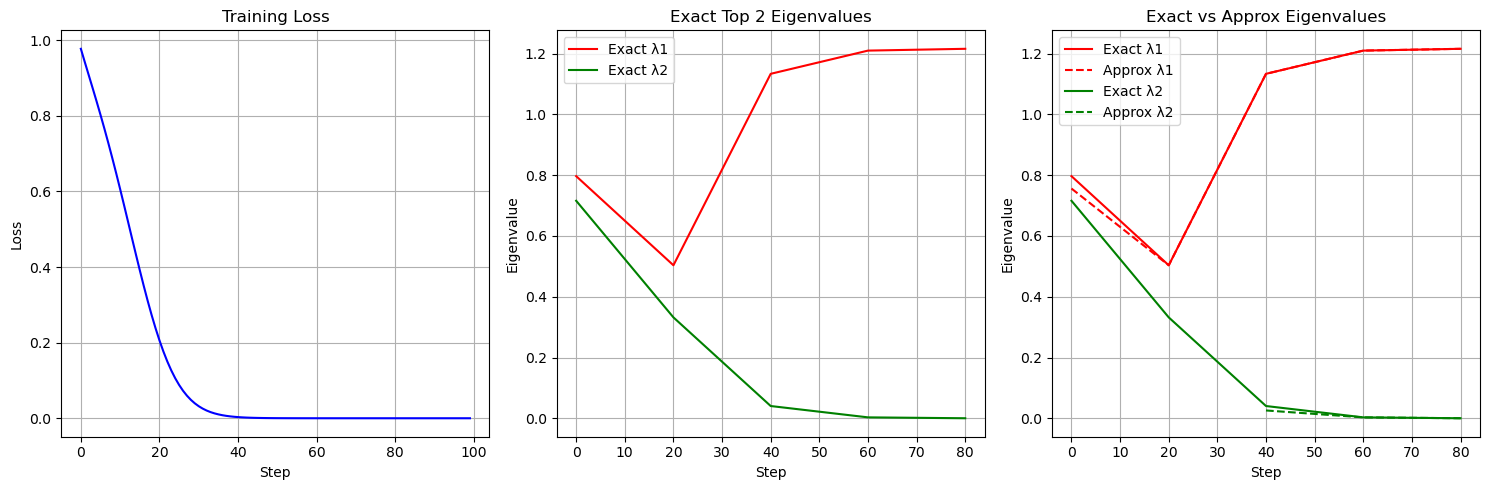

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define simple 2-layer neural network without bias
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(2, 2, bias=False)  # 2x2 weight matrix
        self.layer2 = nn.Linear(2, 1, bias=False)  # 1x2 weight matrix
        
    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = self.layer2(x)
        return x

# Function to compute exact Hessian
def compute_exact_hessian(model, inputs, target, criterion):
    model.eval()
    params = list(model.parameters())
    n_params = sum(p.numel() for p in params)
    
    # Compute loss
    output = model(inputs)
    loss = criterion(output, target)
    
    # First derivatives
    grads = torch.autograd.grad(loss, params, create_graph=True)
    grad_vector = torch.cat([g.flatten() for g in grads])
    
    # Compute Hessian
    hessian = torch.zeros(n_params, n_params)
    for i in range(n_params):
        # Second derivative w.r.t parameter i
        grad_i = torch.autograd.grad(grad_vector[i], params, retain_graph=True)
        grad_i_flat = torch.cat([g.flatten() for g in grad_i])
        hessian[i] = grad_i_flat
    
    return hessian

# Function to compute top 2 eigenvalues using power iteration
def compute_approx_eigenvalues(model, inputs, target, criterion, num_iterations=10):
    model.eval()
    params = [p for p in model.parameters() if p.requires_grad]
    n_params = sum(p.numel() for p in params)
    
    output = model(inputs)
    loss = criterion(output, target)
    grads = torch.autograd.grad(loss, params, create_graph=True)
    grad_vector = torch.cat([g.flatten() for g in grads])
    print("grad_vector:", grad_vector)
    
    top_eigenvalues = []
    top_eigenvectors = []
    v = torch.randn(n_params)
    
    for _ in range(2):
        v = v / torch.norm(v)
        for i in range(num_iterations):
            Hv = torch.zeros_like(v)
            grad_grads = torch.autograd.grad(grad_vector @ v, params, retain_graph=True)
            Hv = torch.cat([gg.flatten() for gg in grad_grads])
            print(f"Iteration {i}:")
            print("grad_grads:", grad_grads)
            print("Hv:", Hv)
            print()
            v_new = Hv / torch.norm(Hv)
            v = v_new
        
        Hv = torch.zeros_like(v)
        grad_grads = torch.autograd.grad(grad_vector @ v, params, retain_graph=True)
        Hv = torch.cat([gg.flatten() for gg in grad_grads])
        eigenvalue = (v @ Hv) / (v @ v)
        top_eigenvalues.append(eigenvalue.item())
        top_eigenvectors.append(v.clone())
        
        grad_vector = grad_vector - (grad_vector @ v) * v
    
    return top_eigenvalues, top_eigenvectors

# Training function with Hessian comparison
def train_model(model, inputs, target, criterion, optimizer, num_steps=100):
    losses = []
    exact_eig_history = []
    approx_eig_history = []
    
    for step in range(num_steps):
        model.train()
        optimizer.zero_grad()
        
        output = model(inputs)
        loss = criterion(output, target)
        
        if step % 20 == 0:  # Compute every 20 steps to reduce output
            # Exact Hessian
            hessian = compute_exact_hessian(model, inputs, target, criterion)
            exact_eigvals, exact_eigvecs = torch.linalg.eigh(hessian)
            top_exact_eigvals = exact_eigvals[-2:].tolist()[::-1]  # Top 2
            top_exact_eigvecs = exact_eigvecs[:, -2:].T.tolist()[::-1]
            
            # Approximated eigenvalues/vectors
            approx_eigvals, approx_eigvecs = compute_approx_eigenvalues(model, inputs, target, criterion)
            
            exact_eig_history.append({
                'step': step,
                'eigenvalues': top_exact_eigvals,
                'eigenvectors': top_exact_eigvecs
            })
            approx_eig_history.append({
                'step': step,
                'eigenvalues': approx_eigvals,
                'eigenvectors': [v.tolist() for v in approx_eigvecs]
            })
            
            print(f"\nStep {step}, Loss: {loss.item():.4f}")
            print(f"Exact top 2 eigenvalues: {[f'{e:.4f}' for e in top_exact_eigvals]}")
            print(f"Approx top 2 eigenvalues: {[f'{e:.4f}' for e in approx_eigvals]}")
            # Cosine similarity between eigenvectors
            for i in range(2):
                cos_sim = torch.dot(
                    torch.tensor(top_exact_eigvecs[i]), 
                    torch.tensor(approx_eigvecs[i])
                ) / (torch.norm(torch.tensor(top_exact_eigvecs[i])) * torch.norm(approx_eigvecs[i]))
                print(f"Eigenvector {i+1} cosine similarity: {cos_sim.item():.4f}")
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return losses, exact_eig_history, approx_eig_history

# Setup
inputs = torch.randn(1, 2)
target = torch.tensor([[1.0]])
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

print("Initial weights:")
print("Layer 1:", model.layer1.weight.data)
print("Layer 2:", model.layer2.weight.data)

# Train and compare
print("\nStarting training...")
losses, exact_eig_history, approx_eig_history = train_model(model, inputs, target, criterion, optimizer)

# Plotting
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(losses, 'b-', label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Exact eigenvalues
steps = [e['step'] for e in exact_eig_history]
exact_eig1 = [e['eigenvalues'][0] for e in exact_eig_history]
exact_eig2 = [e['eigenvalues'][1] for e in exact_eig_history]
plt.subplot(1, 3, 2)
plt.plot(steps, exact_eig1, 'r-', label='Exact λ1')
plt.plot(steps, exact_eig2, 'g-', label='Exact λ2')
plt.xlabel('Step')
plt.ylabel('Eigenvalue')
plt.title('Exact Top 2 Eigenvalues')
plt.grid(True)
plt.legend()

# Comparison plot
approx_eig1 = [e['eigenvalues'][0] for e in approx_eig_history]
approx_eig2 = [e['eigenvalues'][1] for e in approx_eig_history]
plt.subplot(1, 3, 3)
plt.plot(steps, exact_eig1, 'r-', label='Exact λ1')
plt.plot(steps, approx_eig1, 'r--', label='Approx λ1')
plt.plot(steps, exact_eig2, 'g-', label='Exact λ2')
plt.plot(steps, approx_eig2, 'g--', label='Approx λ2')
plt.xlabel('Step')
plt.ylabel('Eigenvalue')
plt.title('Exact vs Approx Eigenvalues')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch
from torch import Tensor
from scipy.sparse.linalg import LinearOperator, eigsh
import time
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Generate synthetic data
n_samples = 200000
n_features = 6000

# Create a diagonal covariance matrix with decreasing values
cov_diag = torch.zeros(n_features, device=device)
cov_diag[0] = 10.0
step_size = (n_features - 10) / (n_features - 1)
for i in range(1, n_features):
    cov_diag[i] = step_size
cov_matrix = torch.diag(cov_diag)

# Create a multivariate normal distribution with mean 0 and our covariance matrix
mvn = torch.distributions.MultivariateNormal(
    loc=torch.zeros(n_features, device=device),
    covariance_matrix=cov_matrix
)

# Generate random normal x by sampling from the multivariate normal distribution
# This will give us a tensor of shape (n_samples, n_features)
x_data = mvn.sample((n_samples,))

# Generate a random unit vector u (the true parameter)
u_true = torch.randn(n_features, device=device)
u_true = u_true / torch.norm(u_true)

# Generate y = x^T u + epsilon
noise_level = 0.1
epsilon = noise_level * torch.randn(n_samples, device=device)
y_data = torch.matmul(x_data, u_true) + epsilon

# Compute the covariance matrix of x_data
x_cov = torch.matmul(x_data.T, x_data) / n_samples

# Compute eigenvalues and eigenvectors of the covariance matrix
eig_vals, eig_vecs = torch.linalg.eigh(x_cov)
# Sort in descending order
sorted_indices = torch.argsort(eig_vals, descending=True)
eig_vals = eig_vals[sorted_indices]
eig_vecs = eig_vecs[:, sorted_indices]

# First eigenvector (corresponding to largest eigenvalue)
first_eigenvector = eig_vecs[:, 0]

# Define the loss function
def loss_fn(y_pred, y_true):
    return torch.mean((1/2) * (y_pred - y_true) ** 2)

# Initialize model parameters randomly
model = torch.nn.Linear(n_features, 1, bias=False).to(device)
torch.nn.init.normal_(model.weight, mean=0.0, std=0.01)

# SGD optimizer without momentum
learning_rate = 2/(eig_vals[0]-0.0001)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

# Training loop - each step uses the full batch
n_steps = 6000
trajectory = []
loss_values = []

for step in range(n_steps):
    # Forward pass with full batch
    y_pred = model(x_data).squeeze()
    loss = loss_fn(y_pred, y_data)
    
    # Store loss
    loss_values.append(loss.item())
    
    # Store projection of weights onto first eigenvector
    w = model.weight.data.squeeze()
    proj = torch.dot(w, first_eigenvector)
    trajectory.append((proj.item(), loss.item()))
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (step + 1) % 1000 == 0:
        print(f'Step [{step+1}/{n_steps}], Loss: {loss.item():.4f}')

# Convert trajectory to numpy for plotting
trajectory = np.array(trajectory)

# Plot the trajectory along the first eigenvector
plt.figure(figsize=(10, 6))
plt.plot(trajectory[:200, 0], trajectory[:200, 1], 'b-', linewidth=2)
plt.plot(trajectory[:200, 0], trajectory[:200, 1], 'ro', alpha=0.5)
plt.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=10, label='Start')
plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'mo', markersize=10, label='End')

plt.xlabel('Projection onto First Eigenvector')
plt.ylabel('Loss Value')
plt.title('Optimization Trajectory along First Eigenvector Direction')
plt.legend()
plt.grid(True)
plt.show()

# Also plot the loss curve over steps
plt.figure(figsize=(10, 6))
plt.plot(loss_values)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs. Step')
plt.grid(True)
plt.show()